# EDA multi-saisons pour Machine Learning

## 1. Chargement de toutes les saisons (2014‚Äì2024)

In [17]:
import pandas as pd
from pathlib import Path

# Chemins
base = Path("../data/curated/")
seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(2014, 2024)]

# Charger le fichier des scores
scores = pd.read_parquet(base / "all_seasons_scores.parquet")

# Charger toutes les saisons pour les features
dfs = []
for s in seasons:
    df = pd.read_parquet(base / f"player_season_{s}.parquet")
    df["season"] = s
    dfs.append(df)

features = pd.concat(dfs, ignore_index=True)

# Fusion des scores + features
df_all = pd.merge(scores, features, on=["PLAYER_ID", "season"], how="left")
df_all["avail"] = df_all["gp"] / 82
df_all.shape


(5312, 14)

## 2. Valeurs manquantes globales

In [8]:
df_all.isna().mean().sort_values(ascending=False) * 100

PLAYER_NAME        48.606928
height_cm           9.167922
weight_kg           9.167922
bmi                 9.167922
age                 9.167922
PLAYER_ID           0.000000
score_100           0.000000
season              0.000000
pts_mean            0.000000
reb_mean            0.000000
ast_mean            0.000000
plus_minus_mean     0.000000
gp                  0.000000
dtype: float64

## 3. √âvolution temporelle de pts_mean

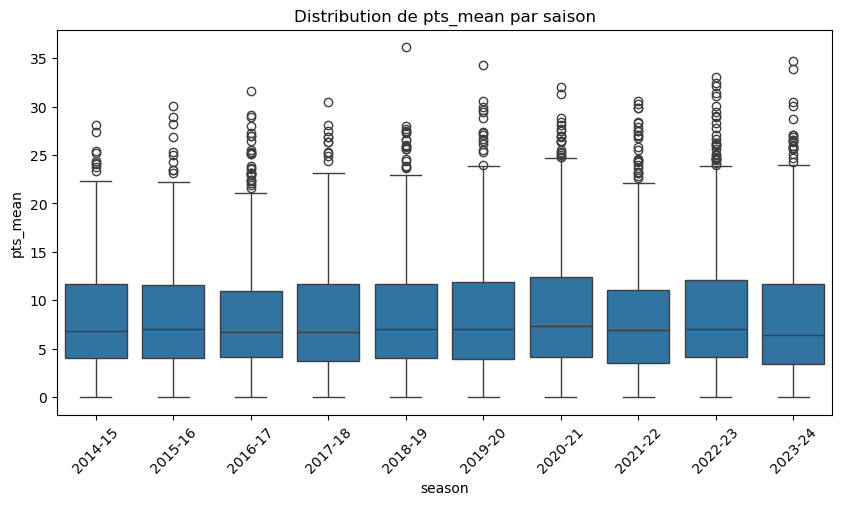

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_all, x='season', y='pts_mean')
plt.title("Distribution de pts_mean par saison")
plt.xticks(rotation=45)
plt.show()

## 4. Corr√©lations globales

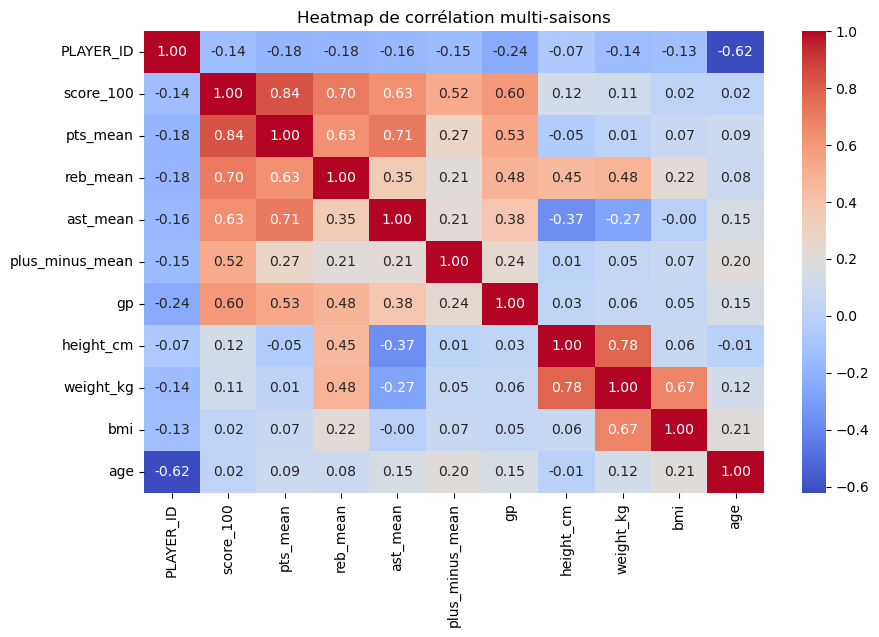

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df_all.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de corr√©lation multi-saisons")
plt.show()

## 5. Pr√©paration du jeu ML : note_n ‚Üí note_n+1

In [11]:
df_all = df_all.sort_values(["PLAYER_ID", "season"])
df_all["note_n"] = df_all["score_100"]
df_all["note_n1"] = df_all.groupby("PLAYER_ID")["score_100"].shift(-1)

# Seulement les lignes avec une target disponible
ml_df = df_all.dropna(subset=["note_n1"])
ml_df[["PLAYER_ID", "season", "note_n", "note_n1"]].head()

PLAYER_ID   season     note_n    note_n1
0          708  2014-15  43.527314  28.137502
1          977  2014-15  55.723842  32.253009
2         1495  2014-15  69.248446  52.567783
3         1713  2014-15  36.042404  24.324586
495       1713  2015-16  24.324586  33.794650

## 6. Corr√©lation entre saison n et saison n+1

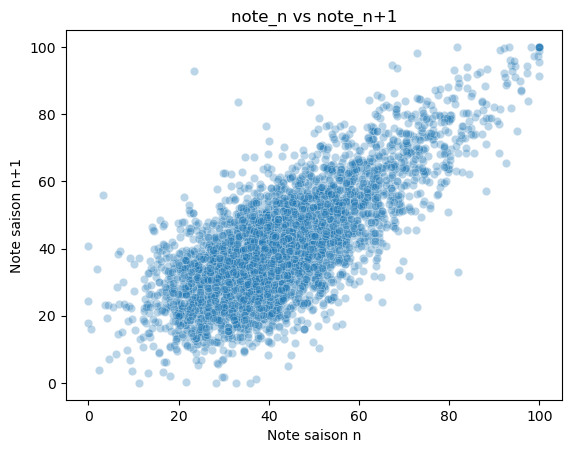

In [12]:
sns.scatterplot(data=ml_df, x="note_n", y="note_n1", alpha=0.3)
plt.title("note_n vs note_n+1")
plt.xlabel("Note saison n")
plt.ylabel("Note saison n+1")
plt.show()

## 7. Conclusion

- Variables les plus stables : `pts_mean`, `reb_mean`, `avail`, `age`
- Corr√©lation forte entre note_n et note_n+1 ‚ûú bon candidat pour pr√©diction
- Prochaine √©tape : pr√©parer X / y pour entra√Æner un mod√®le pr√©dictif.

## 8. Variabilit√© inter-joueurs (constance vs irr√©gularit√©)

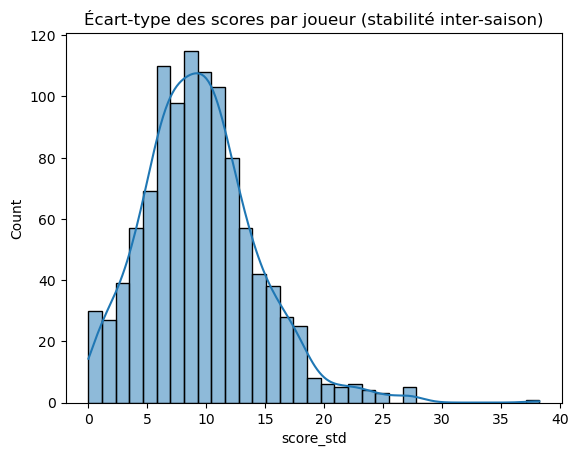

In [13]:
df_std = df_all.groupby("PLAYER_ID")["score_100"].std().reset_index()
df_std.columns = ["PLAYER_ID", "score_std"]
sns.histplot(df_std["score_std"], kde=True)
plt.title("√âcart-type des scores par joueur (stabilit√© inter-saison)")
plt.show()

## 9. Exemple de trajectoire individuelle

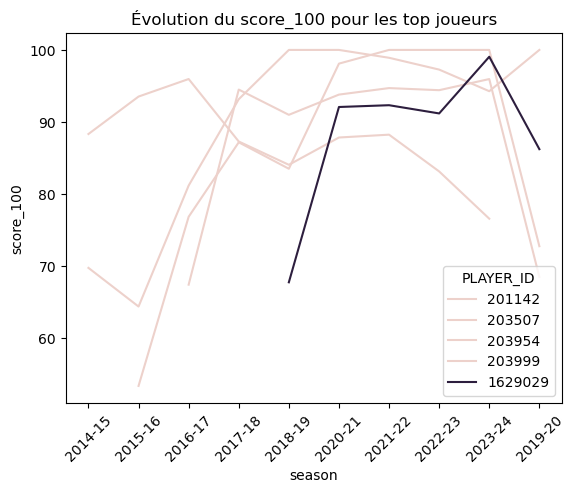

In [14]:
top_players = df_all.groupby("PLAYER_ID")["score_100"].mean().sort_values(ascending=False).head(5).index.tolist()
df_top = df_all[df_all["PLAYER_ID"].isin(top_players)]
sns.lineplot(data=df_top, x="season", y="score_100", hue="PLAYER_ID")
plt.title("√âvolution du score_100 pour les top joueurs")
plt.xticks(rotation=45)
plt.show()

## 10. Stats moyennes par tranche d'√¢ge

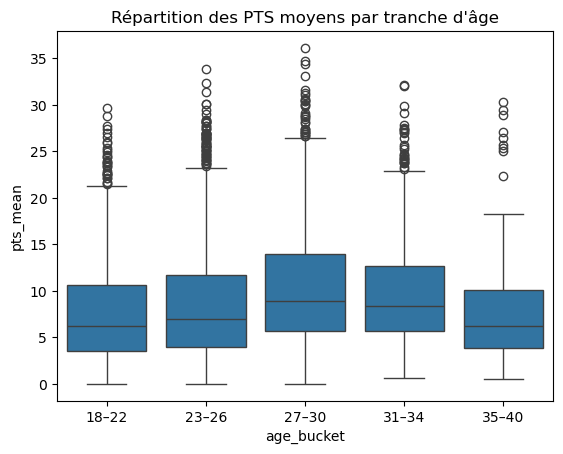

In [15]:
df_all['age_bucket'] = pd.cut(df_all['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18‚Äì22","23‚Äì26","27‚Äì30","31‚Äì34","35‚Äì40"])
sns.boxplot(data=df_all, x="age_bucket", y="pts_mean")
plt.title("R√©partition des PTS moyens par tranche d'√¢ge")
plt.show()

## 11. t-SNE pour visualiser les types de profils joueurs

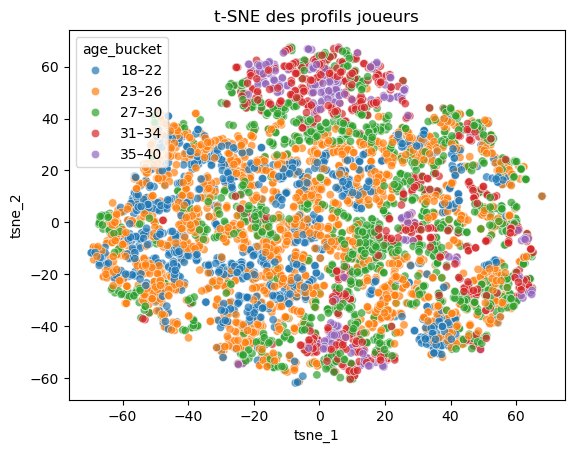

In [19]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
df_visu = df_all.dropna(subset=features).copy()
# Create age_bucket in df_visu similar to how it was created earlier
df_visu['age_bucket'] = pd.cut(df_visu['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18‚Äì22","23‚Äì26","27‚Äì30","31‚Äì34","35‚Äì40"])

X = StandardScaler().fit_transform(df_visu[features])

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
df_visu["tsne_1"], df_visu["tsne_2"] = zip(*tsne.fit_transform(X))
sns.scatterplot(data=df_visu, x="tsne_1", y="tsne_2", hue="age_bucket", alpha=0.7)
plt.title("t-SNE des profils joueurs")
plt.show()

## üîç Visualisation t‚ÄëSNE des profils joueurs

Nous avons projet√© les joueurs NBA sur un plan en 2D √† l‚Äôaide d‚Äôun **t-SNE** (t-distributed stochastic neighbor embedding), bas√© sur leurs caract√©ristiques techniques et physiques :

- `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`
- `avail` (disponibilit√© = GP / 82)
- `height_cm`, `bmi`, `age`

Les couleurs correspondent aux **tranches d‚Äô√¢ge** (`age_bucket`), segment√©es de 18 √† 40 ans.

### üß† Observations :
- Une structure claire √©merge : certains groupes sont **coh√©rents et bien s√©par√©s**.
- Les **joueurs √¢g√©s (31‚Äì34, 35‚Äì40)** sont nettement regroup√©s : leurs profils sont plus homog√®nes.
- Les **plus jeunes (18‚Äì22)** sont davantage dispers√©s ‚Üí profils vari√©s ou en construction.
- Le t-SNE illustre visuellement que l‚Äô**√¢ge est une variable fortement li√©e au style et √† la production**.

Ce graphique sugg√®re qu‚Äôil serait int√©ressant de tester :
- un **clustering** type K-Means sur les m√™mes donn√©es
- ou d‚Äôutiliser ces tranches d‚Äô√¢ge comme feature cat√©gorielle dans les mod√®les ML.


## 12. Conclusion approfondie

- La variabilit√© inter-joueur montre des profils tr√®s stables vs irr√©guliers.
- Les courbes temporelles confirment une forte stabilit√© pour les tops joueurs.
- Les tranches d‚Äô√¢ge influencent nettement la production moyenne.
- Le t-SNE r√©v√®le des regroupements de profils coh√©rents.

‚û°Ô∏è Ces insights serviront √† cr√©er un mod√®le plus pertinent et √† enrichir les features utilis√©es.

---

#  Entra√Ænement d‚Äôun mod√®le de pr√©diction du score_100 (note_n+1)


Ce notebook entra√Æne un mod√®le de machine learning pour pr√©dire le score futur (`note_n+1`) d‚Äôun joueur NBA
√† partir de ses performances et caract√©ristiques physiques de la saison pr√©c√©dente (`note_n`).
Le dataset utilis√© est `dataset_ml.parquet`, g√©n√©r√© pr√©c√©demment.


## 1. Chargement du dataset d'entra√Ænement

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_parquet("../data/curated/dataset_ml.parquet")
X = df.drop(columns="target_note_n1")
y = df["target_note_n1"]
X.shape, y.shape

((3887, 8), (3887,))

## 2. Division train / test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((3109, 8), (778, 8))

## 3. Entra√Ænement du mod√®le : Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 4. √âvaluation du mod√®le

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Manually calculate RMSE instead of using squared=False
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f" R¬≤   : {r2:.2f}")

RMSE : 10.69
 R¬≤   : 0.64


## 5. Importance des variables

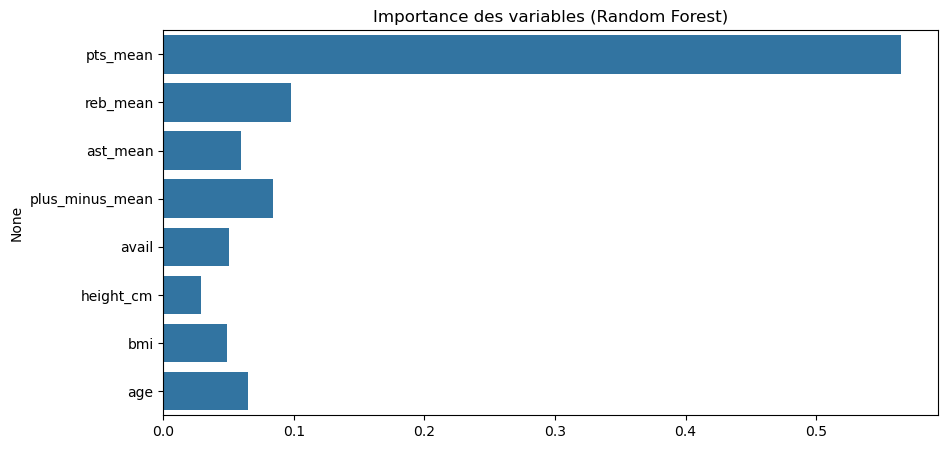

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=features)
plt.title("Importance des variables (Random Forest)")
plt.show()